# Hubbard One Approximation

### Structure of notebook

1. Parameters of the cattering region are defined.
2. Parameters of the fermi dirac function & Integration interval are defined.
3. Electron Density is self-consistently calculated
4. The magnetocurrent $\Delta I(m,V) = I(m) - I(-m)$ is calculated.
5. P value is calculated

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Path to modules

In [2]:
import sys
sys.path.insert(0, '/Users/khhuisman/Documents/Jupyter_notebooks/Coulomb_Paper3_PHS_Collinear/Modules_Coulomb_Github')

# sys.path.insert(0, '<path_to_modules>')

# Chiral Scattering Region

In [3]:
import Sgeom_scatteringregion as Sgeom

# Import NEGF methods

In [4]:
import negf_HIA_git as negf_method           # module containing negf methods with HIA Green's function
import Integration_HIA as Integration_method # module to calculte electron densities methods
import Currents_HIA_git as Current_method    # module to calculate currents
import handy_functions_coulomb as hfc        # module containg "handy functions"
import Pvalue

##  Plot functions electron densities

In [5]:
def plot_densities(nP_list_conv,nM_list_conv,V_list_convg,Hamiltonian0):
    dimlist = hfc.func_list_i(Hamiltonian0)
    plt.title('$n_{is}(m,V) - n_{i\overline{s}}(-m,V)$')
    n_list_total_convgM_swap = [hfc.pairwise_swap([ nM_list_conv[i][k] for k in dimlist]) for i in range(len(V_list_convg))
                              ]
    nP_list_plot =[ [nP_list_conv[i][k] for k in dimlist ] for i in range(len(V_list_convg)) ]


    plt.plot(V_list_convg,np.subtract(nP_list_plot,n_list_total_convgM_swap))
    plt.xlabel('Bias Voltage [eV] ')
    plt.ylabel('Electron Density')
    plt.ticklabel_format(style="sci", scilimits=(0,0))

    plt.show()
    
    
def plot_densities_symmtry_relation(nP_list,nM_list,V_list,dim):
    
    '''
    Input:
        - nP_list,nM_list = electron densities as function of voltages for positive,negative magnetization
        - V_list = list of voltages
        - dim = total number of electron densities
        
    Ouput:
        Plot of "n_{is}(m,V) + n_{i\overline{s}}(-m,-V) - 1" as function of voltage
        this quantity should be zero (within numerical accuracy of integral & tol) 
    '''
    
    dimlist = [i for i in range(dim)]
    ones = [1 for i in range(dim)]
    n_list_swapM = [np.subtract(ones,hfc.pairwise_swap(nM_list[-1-i])) for i in range(len(nM_list))]
    nP_list_plot =[ [nP_list[i][k] for k in dimlist ] for i in range(len(V_list)) ]

    plt.title('$n_{is}(m,V) + n_{i\overline{s}}(-m,-V) - 1$')
    plt.plot(V_list,np.subtract(nP_list_plot,n_list_swapM))
    plt.xlabel('Bias Voltage [eV] ')
    plt.ylabel('Electron Density')
    plt.ticklabel_format(style="sci", scilimits=(0,0))

    plt.show()

# 1. Defining Hamiltonian, Leads

In [6]:
Lm = 2             #number of sites 
Wg = 2

epsilon = 0 # onsite energy
t = 2.4     # hopping paramter

# List of Spin-Orbit Coupling parameter
lambdalist = [
            (1*(10**-1))*t
            ]
# List of interaction strength
Ulist = [ 1.5*t
         ,
        2*t,
         3*t
        ] 


#Gamma Matrix
gammaL = 0.5    # coupling strength
pz    = 0.5    # magnetic polarization

pz_P = abs(pz)
pz_M = -abs(pz)


T = 300 # Kelvin Temperature of leads
betaL,betaR = negf_method.func_beta(T), negf_method.func_beta(T) # 1/ElectronVolt

# 2. Fermi Energy, Energies to integrate over

In [7]:
def func_energies(Hamiltonian0,n00listguess,
                   GammaL,GammaR,U,npoints,npoints_tail,
                   ef,T,Vmax,tol_nintegrand):
    '''
    Input:
    Hamiltonian0 = Hamiltonian of the isolated molecule without interactions (U=0)
    U            = interaction strength
    npoints      = number of energy points in window [emin,emax]
    npointstail = number of energy points in window [emin2,emin)
    Output:
        energiesreal = list of energies to calculate the Glesser integral with.
        emax = upper bound of intergral
        emin = lowest eigenvalue of Hamiltonian0 - 10 eV
        emin2 = lower bound of integral.    
    '''
    
    
    mu_max = ef + Vmax/2            ## largest chemical potential
    beta = negf_method.func_beta(T) ## beta
    
    dim = Hamiltonian0.shape[0]
    
    #Lower bound: 
    ### At lower bound of integral:
    ### <n>  = \int G+ fi Gammai G- dE ~ \int G+ Gammai G- dE
    ### the fermi functions are approximately 1.
    ### The integrand-size is related to the lowest eigenvalue of "Hamiltonian0":
    evlist = np.linalg.eigh(Hamiltonian0)[0]        ##list of eigenvalues
    e_lumo = evlist[int(Hamiltonian0.shape[0]/2)-1] ##lumo energy
    e_homo = evlist[int(Hamiltonian0.shape[0]/2)]   ##homo energy
    hl_gap = e_lumo - e_homo                        ##HL energy
    
    ### Therefore we 'guess' a lowest value:
    emin = np.round(int(10*min(evlist))/10 - 10 ,2) 
    
    ### and check if this falls within a tolerance 'tol_nintegrand':
    emin2 = emin - 20
    boundbool = False
    
    print('Estimating lower bound...')
    while boundbool == False:
        
        emin2 = emin2 - 30
        
        
        nlist_min    =  [ negf_method.ndensity_listi(emin2,
                                                     Hamiltonian0,
                                                     GammaL,GammaR,
                                                    U,n00listguess,
                                                    ef, ef,
                                                    betaL,betaR)[i] for i in range(dim)]

        check_zerob, boundbool = hfc.check_listzero(nlist_min,tol_nintegrand)
#         print(emin2,check_zerob,boundbool)
    
  
    
    
    ### Upper Bound:
    ### Due to fermi dirac function, the integrand of <n>:
    ### <n> = \int G+ fi Gammai G- dE ~ \int fi dE 
    ### will fall off quickly to zero near the energy ef + V/2
    ### Therefore the largest energy we need to consider is close to ef + Vmax/2:
    
    emax = mu_max #intial guess emax
    fmax = negf_method.fermi_dirac(emax,mu_max,beta) #intial guess efmax
    
    
    ### We continue our search iteratively
    while fmax >= tol_nintegrand/1000:
        emax = np.round(emax + 0.5,2)
        fmax = negf_method.fermi_dirac(emax,mu_max,beta)
    
    
    
    
    energies_tail = np.linspace(emin2,emin,npoints_tail)  #In wide band limit the integrand has a long "tail"
    energiesreal_prime = np.linspace( emin, emax,npoints) 
    energiesreal = np.unique(hfc.jointwolist(energies_tail,energiesreal_prime))
   
    return emin2,emin,emax,npoints,energiesreal

# 2.  Bias window

In [8]:
Vmax = 0 # Maximum bias voltage [eV]
dV   = 0.1 # stepsize
V_list_pos_bias,V_list_total = hfc.func_V_total(Vmax,dV)
print(V_list_pos_bias,V_list_total)

[] [0]


# 2. Energes to integrate over

Comment on the convergence: 
- For big $U$ $(U > t)$ use $\alpha \in [0,0.1]$.
- For small $U$ $(U < t)$ use $\alpha > 0.75 $.

In [15]:
tol                 = 1*10**-5 #tolerance on the electron densities 
tol_nintegrand      = 10**-7  #cut-off for integral over Glesser function
max_iteration       = 900      #maximum number of iterations
npoints             = 30000    #npoints energy point for Glesser integral [emin,emax]
npoints_tail        = 10000    #npoints energy point for Glesser integral [emin2,emin]
alpha               = 0.1      #linear mixing paramters

#### Set Coulomb interaction strength and SOC paramter

In [16]:
U       = Ulist[2]
lambda1 = lambdalist[0]
gammaR = gammaL
Hamiltonian0,GammaR,GammaLP,GammaLM = Sgeom.hamiltonian_multiplesites_coupled_asym(Lm,Wg, t,lambda1,gammaL,gammaR,pz,plotbool=False)


emin2,emin,emax,npoints,energies = func_energies(Hamiltonian0,hfc.list_halves(Hamiltonian0),
                                                       GammaLP,GammaR,U,npoints,npoints_tail,
                                                       0,T,Vmax,tol_nintegrand)

Estimating lower bound...


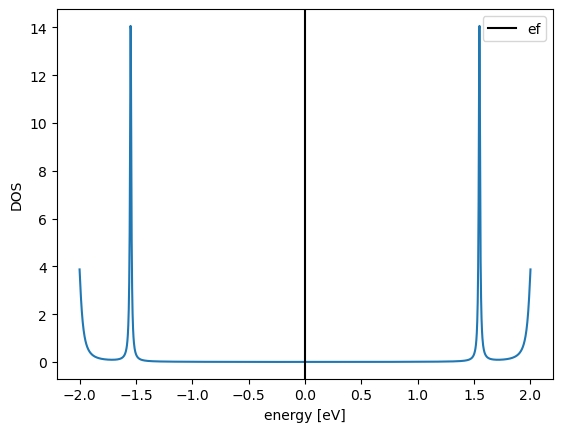

In [17]:
###### DOS plot to see that ef is in between the HOMO,LUMO level (these are the first two peaks one sees w.r.t. EF = U/2):
Integration_method.plot_DOS([0],
                                   [hfc.halves_list(Hamiltonian0)],
0,U,Hamiltonian0, GammaLP,GammaR,0,False)

# 3. Electron Densities

Note: Hubbard One converges well for large U 

In [18]:
eflist = np.linspace(-3,3,32)
eflist

array([-3.        , -2.80645161, -2.61290323, -2.41935484, -2.22580645,
       -2.03225806, -1.83870968, -1.64516129, -1.4516129 , -1.25806452,
       -1.06451613, -0.87096774, -0.67741935, -0.48387097, -0.29032258,
       -0.09677419,  0.09677419,  0.29032258,  0.48387097,  0.67741935,
        0.87096774,  1.06451613,  1.25806452,  1.4516129 ,  1.64516129,
        1.83870968,  2.03225806,  2.22580645,  2.41935484,  2.61290323,
        2.80645161,  3.        ])

In [21]:
paramlist_tot = []

nlist_total = []

for ef in eflist:
    
    gammaR = gammaL
    
    
    print(gammaR,gammaL)
    
    Hamiltonian0,GammaR,GammaLP,GammaLM = Sgeom.hamiltonian_multiplesites_coupled_asym(Lm,Wg, t,lambda1,gammaL,gammaR,pz,plotbool=False)


    emin2,emin,emax,npoints,energies = func_energies(Hamiltonian0,hfc.list_halves(Hamiltonian0),
                                                       GammaLP,GammaR,U,npoints,npoints_tail,
                                                       ef,T,Vmax,tol_nintegrand)
    print(emin2,emin,emax)




    print('ef = {},lambda1/t = {} ,U/t = {}'.format(ef,lambda1/t,U/t) )



    n00_list_guess = hfc.list_halves(Hamiltonian0)
    nP_list,convglistP = Integration_method.self_consistent_trapz_mixing_in([0],Vmax,
                                  n00_list_guess,
                                  max_iteration,
                                ef,
                                U,
                                Hamiltonian0,
                                GammaLP,GammaR, 
                                betaL, betaR,tol,energies,tol_nintegrand,alpha,plot_bool=False,trackbool=False)
    
    nM_list, convglistM = Integration_method.self_consistent_trapz_mixing_in([0],Vmax,
                                  n00_list_guess,
                                  max_iteration,
                                ef,
                                U,
                                Hamiltonian0,
                                GammaLM,GammaR, 
                                betaL, betaR,tol,energies,tol_nintegrand,alpha,plot_bool=False,trackbool=False)
    
    
   
    nlist_total.append([ nP_list,convglistP,nM_list, convglistM])
 
    

    
path = 'ElecDens_EF_HIA/'


string = 'Lm{}_Wg{}_pz{}_tcoupLR{}_{}_T{}_alpha{}_t{}_U{}_lambda1{}_tol{}_efmax{}_lenef{}_emin2{}_emin{}_emax{}_npoints{}_ntail{}_tolintegrand{}.txt'.format(Lm,Wg,
                                                                                                                                                                        pz,gammaL,gammaR,T,
                                                                                                                                                                    alpha,t,
                                                                                                                                                                U,lambda1,tol,
                                                                                                                                                                 max(eflist),
                                                                                                                                                                         len(eflist),
                                                                                                                                                              emin2,emin,emax,npoints,
                                                                                                                                                              npoints_tail,tol_nintegrand)



nPlist_total = []
nMlist_total = []
eflist_adj = []

for k in range(len(eflist)):
    nP_list,convglistP,nM_list, convglistM = nlist_total[k]
    print(sum(nP_list[0])-sum(nM_list[0]))
    if convglistP[0] == True and convglistM[0] == True:
        nPlist_total.append(sum(nP_list[0]))
        nMlist_total.append(sum(nM_list[0]))
        eflist_adj.append(eflist[k])
        
        
        

np.savetxt(path + 'nP_fermi_conv' + string ,nPlist_total)
np.savetxt(path + 'nM_fermi_conv' + string ,nMlist_total)
np.savetxt(path + 'eflist_convg' + string,eflist_adj)


parametersfile = open(path + 'parameter_hia_col' + string, "w")
parametersfile.write(str([Lm,Wg,
                        pz,gammaL,gammaR,T,
                    alpha,t,
                U,lambda1,tol,
                 max(eflist),
                         len(eflist),
              emin2,emin,emax,npoints,
              npoints_tail,tol_nintegrand]))
parametersfile.close()


0.5 0.5
Estimating lower bound...
-1566.8 -16.8 -2.0
ef = -3.0,lambda1/t = 0.1 ,U/t = 3.0
--- V = 0 ---
[0.11527 0.12179 0.10601 0.11102 0.08319 0.08151 0.08541 0.08407 0.14057
 0.14101 0.1388  0.14281 0.08417 0.08538 0.08301 0.08178 0.10775 0.10913
 0.11655 0.12037]
[0.02901 0.02977 0.0295  0.03082 0.02643 0.02811 0.02386 0.02495 0.03609
 0.0367  0.03711 0.03573 0.02405 0.02483 0.02644 0.02812 0.02999 0.0303
 0.02967 0.02911]
[0.00701 0.00759 0.00815 0.0085  0.00896 0.00838 0.00712 0.00679 0.00893
 0.00894 0.00858 0.00931 0.00698 0.00695 0.00891 0.00842 0.0083  0.00836
 0.00705 0.00757]
[0.00184 0.00183 0.00228 0.00242 0.00259 0.00296 0.00191 0.00212 0.00215
 0.0022  0.00234 0.00202 0.00196 0.00208 0.0026  0.00294 0.00233 0.00237
 0.00192 0.00175]
[0.00043 0.0005  0.00067 0.00067 0.00096 0.0008  0.00063 0.00055 0.00051
 0.00052 0.00044 0.0006  0.00061 0.00057 0.00095 0.00081 0.00068 0.00067
 0.00042 0.00051]
[1.2e-04 1.1e-04 1.8e-04 2.1e-04 2.3e-04 3.3e-04 1.5e-04 2.0e-04 1.2e-04
 1.2

[0.00134 0.0006  0.00112 0.00083 0.00214 0.00199 0.00139 0.00101 0.00105
 0.00125 0.00116 0.00114 0.00118 0.00118 0.00214 0.00198 0.00119 0.00079
 0.00124 0.00068]
[9.0e-05 4.2e-04 2.5e-04 3.4e-04 6.6e-04 7.3e-04 3.2e-04 4.8e-04 4.3e-04
 4.0e-04 4.2e-04 3.9e-04 3.9e-04 4.1e-04 6.5e-04 7.4e-04 2.3e-04 3.7e-04
 1.4e-04 3.7e-04]
[1.6e-04 1.0e-05 1.1e-04 8.0e-05 2.5e-04 2.1e-04 1.8e-04 9.0e-05 1.4e-04
 1.4e-04 1.4e-04 1.4e-04 1.4e-04 1.3e-04 2.6e-04 2.0e-04 1.2e-04 7.0e-05
 1.2e-04 2.0e-05]
[2.e-05 6.e-05 3.e-05 3.e-05 7.e-05 9.e-05 2.e-05 7.e-05 4.e-05 5.e-05
 5.e-05 5.e-05 4.e-05 5.e-05 6.e-05 1.e-04 2.e-05 4.e-05 0.e+00 4.e-05]
[3.e-05 2.e-05 0.e+00 1.e-05 3.e-05 2.e-05 3.e-05 0.e+00 2.e-05 1.e-05
 2.e-05 2.e-05 2.e-05 1.e-05 4.e-05 2.e-05 2.e-05 0.e+00 2.e-05 0.e+00]
[1.e-05 1.e-05 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 1.e-05 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5 0.5
Estimating lower bound...
-15

[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0 ---
[0.0444  0.04429 0.03657 0.03693 0.05289 0.05159 0.04576 0.0453  0.01498
 0.01508 0.01474 0.01531 0.0455  0.04554 0.0527  0.05176 0.03701 0.03652
 0.04462 0.04409]
[0.02004 0.019   0.01857 0.01735 0.02016 0.01976 0.01742 0.0171  0.00829
 0.00814 0.00871 0.00771 0.01724 0.01728 0.01993 0.01998 0.01802 0.01791
 0.01985 0.01919]
[0.00842 0.00852 0.00839 0.00861 0.00798 0.00782 0.00659 0.0066  0.00461
 0.00472 0.00439 0.00493 0.00661 0.00658 0.00799 0.00781 0.00855 0.00845
 0.00843 0.00851]
[0.00377 0.00351 0.00416 0.00379 0.00322 0.00313 0.00263 0.0025  0.00274
 0.00263 0.00295 0.00242 0.00255 0.00258 0.00316 0.00319 0.00398 0.00397
 0.00374 0.00353]
[0.00152 0.00158 0.00179 0.00191 0.0013  0.00127 0.00099 0.00104 0.0015
 0.00159 0.00137 0.00172 0.00102 0.001   0.00131 0.00126 0.00186 0.00184


[0.00032 0.00133 0.00077 0.00157 0.00183 0.00173 0.00168 0.00161 0.00212
 0.00227 0.00216 0.00222 0.00153 0.00178 0.00165 0.00192 0.0011  0.00123
 0.00076 0.00085]
[0.00064 0.      0.00082 0.00035 0.00073 0.00083 0.00059 0.00063 0.0013
 0.00119 0.00128 0.00122 0.00067 0.00055 0.00085 0.00072 0.00062 0.00055
 0.00034 0.00031]
[0.0001  0.00037 0.00014 0.00048 0.00038 0.00029 0.00024 0.00021 0.00066
 0.00076 0.00068 0.00074 0.00018 0.00027 0.0003  0.00039 0.00029 0.00033
 0.00012 0.00013]
[2.0e-04 1.2e-04 2.7e-04 6.0e-05 1.0e-04 1.8e-04 7.0e-05 9.0e-05 4.5e-04
 3.7e-04 4.4e-04 3.8e-04 1.1e-04 6.0e-05 1.7e-04 1.2e-04 1.8e-04 1.5e-04
 4.0e-05 4.0e-05]
[1.0e-04 1.3e-04 2.0e-05 1.6e-04 9.0e-05 2.0e-05 3.0e-05 2.0e-05 2.0e-04
 2.7e-04 2.1e-04 2.6e-04 1.0e-05 5.0e-05 4.0e-05 7.0e-05 8.0e-05 1.0e-04
 2.0e-05 0.0e+00]
[8.0e-05 8.0e-05 9.0e-05 0.0e+00 0.0e+00 5.0e-05 0.0e+00 1.0e-05 1.6e-04
 1.1e-04 1.6e-04 1.1e-04 2.0e-05 0.0e+00 3.0e-05 1.0e-05 6.0e-05 5.0e-05
 0.0e+00 0.0e+00]
[6.e-05 6.e-05 0.

[1.9e-04 3.0e-05 2.2e-04 1.1e-04 9.0e-05 1.3e-04 3.0e-05 4.0e-05 2.1e-04
 1.9e-04 2.1e-04 1.9e-04 5.0e-05 3.0e-05 1.2e-04 1.0e-04 1.7e-04 1.6e-04
 1.1e-04 1.0e-04]
[0.0e+00 1.1e-04 6.0e-05 1.3e-04 7.0e-05 3.0e-05 2.0e-05 1.0e-05 1.1e-04
 1.3e-04 1.1e-04 1.3e-04 0.0e+00 2.0e-05 4.0e-05 6.0e-05 9.0e-05 1.0e-04
 5.0e-05 6.0e-05]
[7.e-05 2.e-05 8.e-05 3.e-05 1.e-05 4.e-05 0.e+00 0.e+00 8.e-05 6.e-05
 8.e-05 6.e-05 1.e-05 0.e+00 3.e-05 2.e-05 6.e-05 5.e-05 3.e-05 3.e-05]
[2.e-05 5.e-05 1.e-05 5.e-05 2.e-05 0.e+00 0.e+00 0.e+00 3.e-05 5.e-05
 3.e-05 5.e-05 0.e+00 0.e+00 0.e+00 1.e-05 3.e-05 3.e-05 1.e-05 2.e-05]
[3.e-05 2.e-05 3.e-05 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 3.e-05 2.e-05
 3.e-05 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05 2.e-05 0.e+00 0.e+00]
[2.e-05 2.e-05 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05
 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00]
[2.e-05 1.e-05 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00
 1.e-05 0.e+00 0.e+00 0.e+00 

[5.e-05 4.e-05 5.e-05 4.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[3.e-05 4.e-05 3.e-05 4.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[3.e-05 3.e-05 3.e-05 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[2.e-05 2.e-05 2.e-05 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[2.e-05 2.e-05 2.e-05 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[1.e-05 1.e-05 1.e-05 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[1.e-05 1.e-05 1.e-05 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]

[1.2e-04 0.0e+00 1.2e-04 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.0e-05 6.0e-05
 6.0e-05 6.0e-05]
[0.e+00 9.e-05 0.e+00 9.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 4.e-05 4.e-05 4.e-05 4.e-05]
[6.e-05 1.e-05 6.e-05 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05 2.e-05 2.e-05 2.e-05]
[2.e-05 4.e-05 2.e-05 4.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05 1.e-05 1.e-05]
[3.e-05 2.e-05 3.e-05 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[1.e-05 2.e-05 1.e-05 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[2.e-05 1.e-05 2.e-05 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 

[0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5 0.5
Estimating lower bound...
-1566.8 -16.8 0.71
ef = -0.2903225806451615,lambda1/t = 0.1 ,U/t = 3.0
--- V = 0 ---
[8.e-05 3.e-05 8.e-05 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 5.e-05 5.e-05 5.e-05 5.e-05]
[1.e-05 6.e-05 1.e-05 6.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 3.e-05 3.e-05 3.e-05 3.e-05]
[4.e-05 0.e+00 4.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05 2.e-05 2.e-05 2.e-05]
[0.e+00 3.e-05 0.e+00 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05 1.e-05 1.e-05]
[2.e-05 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e

-1566.8 -16.8 1.48
ef = 0.4838709677419355,lambda1/t = 0.1 ,U/t = 3.0
--- V = 0 ---
[5.e-05 2.e-05 5.e-05 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 3.e-05 3.e-05 3.e-05 3.e-05]
[0.e+00 3.e-05 0.e+00 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05 2.e-05 2.e-05 2.e-05]
[2.e-05 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05 1.e-05 1.e-05]
[0.e+00 2.e-05 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[1.e-05 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0 ---
[2.e-05 5.e-05 2.e-05 5.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 3.e-05 3.e-05 3.e-05 3.e-05]
[3

[6.5e-04 2.2e-04 6.6e-04 2.2e-04 6.0e-05 2.0e-05 8.0e-05 3.0e-05 1.0e-05
 0.0e+00 1.0e-05 0.0e+00 6.0e-05 5.0e-05 4.0e-05 4.0e-05 4.4e-04 4.4e-04
 4.4e-04 4.4e-04]
[8.0e-05 4.4e-04 8.0e-05 4.5e-04 0.0e+00 3.0e-05 0.0e+00 4.0e-05 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 2.0e-05 2.0e-05 2.0e-05 2.0e-05 2.6e-04 2.6e-04
 2.6e-04 2.6e-04]
[2.9e-04 1.0e-05 3.0e-04 2.0e-05 0.0e+00 0.0e+00 1.0e-05 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.6e-04 1.6e-04
 1.5e-04 1.5e-04]
[2.0e-05 2.1e-04 2.0e-05 2.1e-04 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 9.0e-05 9.0e-05
 9.0e-05 9.0e-05]
[1.4e-04 3.0e-05 1.5e-04 3.0e-05 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.0e-05 6.0e-05
 5.0e-05 5.0e-05]
[4.0e-05 1.0e-04 4.0e-05 1.1e-04 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 3.0e-05 3.0e-05
 3.0e-05 3.0e-05]
[7.e-05 4.e-05 8

[2.1e-04 8.0e-05 2.2e-04 8.0e-05 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 1.0e-05 0.0e+00 0.0e+00 0.0e+00 6.0e-05 7.0e-05
 6.0e-05 6.0e-05]
[7.0e-05 1.4e-04 8.0e-05 1.5e-04 0.0e+00 0.0e+00 0.0e+00 1.0e-05 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e-05 0.0e+00 0.0e+00 4.0e-05 4.0e-05
 4.0e-05 3.0e-05]
[1.1e-04 6.0e-05 1.2e-04 7.0e-05 0.0e+00 0.0e+00 1.0e-05 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 1.0e-05 0.0e+00 0.0e+00 0.0e+00 2.0e-05 2.0e-05
 2.0e-05 2.0e-05]
[6.e-05 8.e-05 6.e-05 8.e-05 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05 1.e-05 1.e-05]
[6.e-05 4.e-05 7.e-05 5.e-05 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[4.e-05 4.e-05 4.e-05 5.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[3.e-05 3.e-05 4.e-05 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 

[6.e-05 6.e-05 0.e+00 6.e-05 3.e-05 1.e-05 0.e+00 0.e+00 6.e-05 1.e-04
 6.e-05 1.e-04 0.e+00 0.e+00 0.e+00 1.e-05 3.e-05 3.e-05 0.e+00 0.e+00]
[4.e-05 5.e-05 3.e-05 0.e+00 2.e-05 2.e-05 0.e+00 0.e+00 6.e-05 3.e-05
 6.e-05 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05 1.e-05 0.e+00 0.e+00]
[3.e-05 3.e-05 0.e+00 2.e-05 1.e-05 1.e-05 0.e+00 0.e+00 1.e-05 4.e-05
 1.e-05 4.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00]
[2.e-05 2.e-05 1.e-05 0.e+00 1.e-05 1.e-05 0.e+00 0.e+00 3.e-05 0.e+00
 3.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[2.e-05 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05
 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[1.e-05 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00
 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[1.e-05 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]

[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00
 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5 0.5
Estimating lower bound...
-1566.8 -16.8 3.23
ef = 2.225806451612903,lambda1/t = 0.1 ,U/t = 3.0
--- V = 0 ---
[0.04414 0.04435 0.03678 0.03652 0.05159 0.05289 0.0453  0.04576 0.01508
 0.01498 0.01531 0.01474 0.04554 0.0455  0.05176 0.0527  0.03642 0.0369
 0.04399 0.04452]
[0.01899 0.01997 0.01734 0.01851 0.01975 0.02014 0.0171  0.01741 0.00813
 0.00828 0.00771 0.0087  0.01728 0.01724 0.01997 0.01991 0.01787 0.01798
 0.01915 0.01981]
[0.00849 0.00842 0.00857 0.00839 0.00781 0.00798 0.0066  0.00659 0.00472
 0.0046  0.00492 0.00439 0.00658 0.00661 0.0078  0.00799 0.00844 0.00853
 0.00849 0.00842]
[0.00351 0.00375 0.00379 0.00415 0.00313 0.00322 0.0025  0.00262

[0.02087 0.01922 0.01922 0.01645 0.02132 0.01973 0.01763 0.01676 0.00651
 0.00606 0.00779 0.00487 0.01733 0.01707 0.02066 0.02035 0.01799 0.01761
 0.0208  0.0193 ]
[0.0082  0.00845 0.00729 0.0081  0.00752 0.00786 0.006   0.00637 0.0018
 0.00197 0.00122 0.00257 0.0062  0.00618 0.00769 0.00768 0.00764 0.00775
 0.00806 0.00859]
[3.63e-03 3.22e-03 3.76e-03 2.92e-03 3.23e-03 2.89e-03 2.45e-03 2.12e-03
 6.70e-04 5.80e-04 1.21e-03 9.00e-05 2.28e-03 2.29e-03 3.07e-03 3.04e-03
 3.36e-03 3.27e-03 3.66e-03 3.20e-03]
[0.00131 0.00145 0.00123 0.00161 0.00118 0.00128 0.00076 0.00094 0.00016
 0.0002  0.00017 0.00054 0.00087 0.00083 0.00124 0.00123 0.0014  0.00143
 0.00128 0.00149]
[6.2e-04 4.9e-04 7.6e-04 4.7e-04 5.5e-04 4.8e-04 3.9e-04 2.5e-04 5.0e-05
 3.0e-05 3.1e-04 2.1e-04 3.0e-04 3.4e-04 5.1e-04 5.1e-04 6.1e-04 5.9e-04
 6.3e-04 4.8e-04]
[1.9e-04 2.5e-04 1.8e-04 3.4e-04 2.0e-04 2.2e-04 8.0e-05 1.7e-04 0.0e+00
 0.0e+00 1.8e-04 1.8e-04 1.4e-04 1.0e-04 2.2e-04 2.1e-04 2.6e-04 2.6e-04
 1.8e-04 2.6e-0

[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5 0.5
Estimating lower bound...
-1566.8 -16.8 4.0
ef = 3.0,lambda1/t = 0.1 ,U/t = 3.0
--- V = 0 ---
[0.11511 0.12174 0.10585 0.11097 0.08319 0.08151 0.08541 0.08407 0.14057
 0.14101 0.1388  0.14281 0.08417 0.08538 0.08301 0.08178 0.10765 0.10903
 0.11645 0.12027]
[0.02901 0.02972 0.0295  0.03077 0.02643 0.02811 0.02386 0.02495 0.03609
 0.0367  0.03711 0.03573 0.02405 0.02482 0.02644 0.02811 0.02996 0.03027
 0.02965 0.02908]
[0.007   0.0076  0.00814 0.00851 0.00895 0.00838 0.00712 0.00678 0.00893
 0.00894 0.00858 0.00931 0.00698 0.00695 0.00891 0.00842 0.00829 0.00835
 0.00705 0.00756]
[0.00184 0.00182 0.00229 0.00241 0.00259 0.00296 0.00191 0.00212 0.00215
 0.0022  0.00234 0.00202 0.00196 0.00208 0.0026  0.00294 0.00233 0.00237
 0.00191 0.00175]
[0.00043 0.0005  0.00067 0.00068 0.00096 0.0008  0.00063 

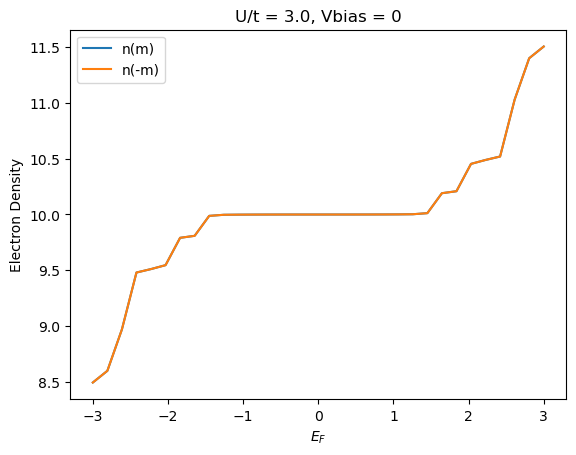

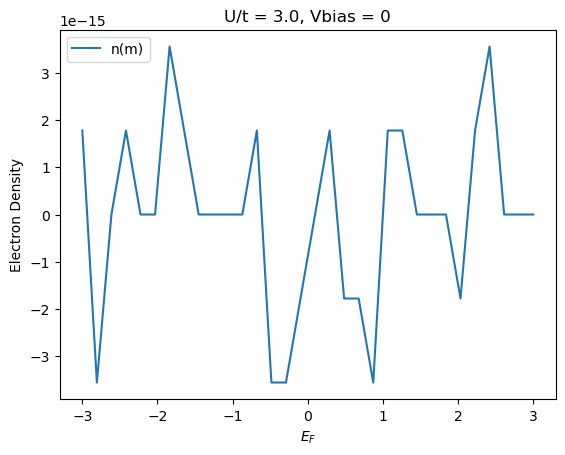

In [23]:
plt.title('U/t = {}, Vbias = 0'.format(U/t))
plt.plot(eflist_adj,nPlist_total,label = 'n(m)')
plt.plot(eflist_adj,nMlist_total,label = 'n(-m)')
plt.xlabel('$E_F$')
plt.ylabel('Electron Density')
plt.legend()
plt.show()

plt.title('U/t = {}, Vbias = 0'.format(U/t))
plt.plot(eflist_adj,np.subtract(nPlist_total,nMlist_total),label = 'n(m)')
# plt.plot(eflist_adj,nMlist_total,label = 'n(-m)')
plt.xlabel('$E_F$')
plt.ylabel('Electron Density')
plt.legend()
plt.show()

In [43]:

def func_ef_var(Hamiltonian0,deltan,
                nPlist_total,eflist_adj):

    dim = Hamiltonian0.shape[0]
    ne_half = dim/2
    nemax = ne_half + abs(deltan)
    nemin = ne_half - abs(deltan)

    ef_target_list = []


    for k in range(len(eflist_adj)):

        nek = nPlist_total[k]

        if nek <= nemax and nek >= nemin:
            ef_target_list.append(eflist_adj[k])
    return ef_target_list 

In [52]:
ef_target_list = func_ef_var(Hamiltonian0,0.3,
                nPlist_total,eflist_adj)

In [53]:
print(ef_target_list)

[-1.838709677419355, -1.6451612903225807, -1.4516129032258065, -1.2580645161290323, -1.064516129032258, -0.870967741935484, -0.67741935483871, -0.4838709677419355, -0.2903225806451615, -0.09677419354838701, 0.09677419354838701, 0.29032258064516103, 0.4838709677419355, 0.6774193548387095, 0.870967741935484, 1.064516129032258, 1.258064516129032, 1.451612903225806, 1.64516129032258, 1.838709677419355]
